In [4]:
from operator import mul
import urllib2
import numpy as np
im_shape = (480, 640, 3)
im_sz = reduce(mul, im_shape)

def from_buffer(im_str):
    f1 = np.fromstring(im_str, dtype=np.uint8)
    return f1.reshape((480, 640, 3))    
    
def get_images():
    response=urllib2.urlopen('http://localhost:8889/camera')
    left = from_buffer(response.read(im_sz))
    right = from_buffer(response.read(im_sz))
    response.close()
    return left, right

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt


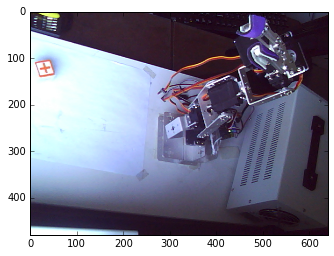

In [240]:
left_im, right_im = get_images()

plt.imshow(left_im)

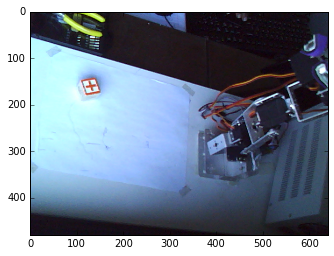

In [241]:
plt.imshow(right_im)

In [226]:
import json
def get_ps3_out():
    response=urllib2.urlopen('http://localhost:8888/get')
    js, buttons = json.loads(''.join(response.readlines()))
    pressed_buttons = []
    for (button, state) in js.items():
        if state > 0.5:
            pressed_buttons.append(button)
        if state < -0.5 and button == '1':
            pressed_buttons.append('0')
            
    for (button, state) in buttons.items():
        if state > 0.5:
            pressed_buttons.append(button)
    return pressed_buttons

In [234]:
get_ps3_out()

['0']

In [139]:
    motor_state = {0:1500, 1:1500, 2:1500, 3:1500, 4:1500, 5:1500}
    move_robot()
    import time
    def move_robot():
        url = 'http://localhost:8889/robot/%d/%d/%d/%d/%d/%d/'
        ms = [l[1] for l in sorted(motor_state.items(), key=lambda x: x[0])]
        call_url = url%tuple(ms)
        print call_url
        time.sleep(0.1)
        response = urllib2.urlopen(call_url)
        return response.readlines()

    def update_state(motor_id, update_direction):
        motor_state[motor_id] = motor_state[motor_id] + 50*update_direction
        move_robot()

http://localhost:8889/robot/1500/1500/1500/1500/1500/1500/


In [238]:
button_motor_map = {"0": [0, -1], "1": [0, +1], 
                    "2": [1, -1], "3": [1, +1],
                    "8": [2, -1], "10":[2, +1],
                    "9": [3, -1], "11":[3, +1],
                    "4": [4, -1], "6": [4, +1],
                    "14":[5, -1], "12":[5, +1]}

    while True:
        time.sleep(0.3)
        pressed = get_ps3_out()
        for press in pressed:
            motor, direction = button_motor_map[press]
            update_state(motor, direction)
    

http://localhost:8889/robot/1300/2150/1300/1450/1350/1300/
http://localhost:8889/robot/1300/2150/1300/1450/1350/1350/
http://localhost:8889/robot/1300/2150/1300/1450/1350/1400/
http://localhost:8889/robot/1300/2150/1300/1450/1350/1450/
http://localhost:8889/robot/1300/2150/1300/1450/1350/1500/
http://localhost:8889/robot/1300/2150/1300/1450/1350/1550/
http://localhost:8889/robot/1300/2150/1300/1450/1350/1600/
http://localhost:8889/robot/1300/2150/1300/1450/1350/1550/
http://localhost:8889/robot/1300/2100/1300/1450/1350/1550/
http://localhost:8889/robot/1300/2050/1300/1450/1350/1550/
http://localhost:8889/robot/1300/2000/1300/1450/1350/1550/
http://localhost:8889/robot/1300/1950/1300/1450/1350/1550/
http://localhost:8889/robot/1300/1900/1300/1450/1350/1550/
http://localhost:8889/robot/1300/1850/1300/1450/1350/1550/
http://localhost:8889/robot/1300/1800/1300/1450/1350/1550/
http://localhost:8889/robot/1300/1750/1300/1450/1350/1550/
http://localhost:8889/robot/1300/1700/1300/1450/1350/155

KeyboardInterrupt: 